🧹 Registros eliminados por falta de fecha (No Registrados): 0


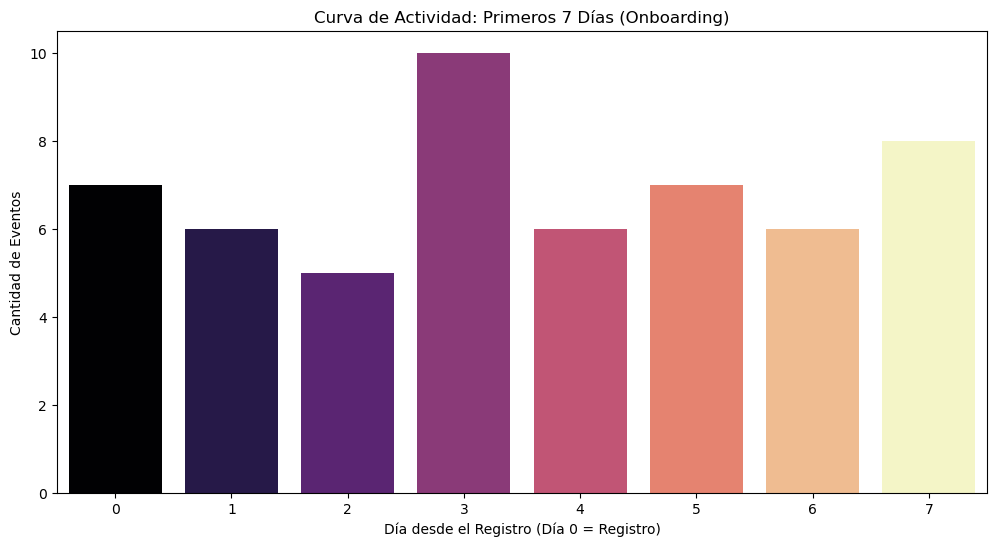


Comportamiento en la primera semana (%):
Tipo_Evento
inicio de sesion                      43.636364
Sesión de Entrenamiento Completada    32.727273
Interacción con Contenido             23.636364
Name: proportion, dtype: float64


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Carga de datos
df = pd.read_csv('../data/processed/df_maestro_unificado_scored.csv')

# 2. Conversión segura de fechas
# errors='coerce' transformará "No Registrado" en NaT (nulo)
df['Fecha_Actividad'] = pd.to_datetime(df['Fecha_Actividad'], errors='coerce')
df['Fecha_Inicio'] = pd.to_datetime(df['Fecha_Inicio'], errors='coerce')

# 3. Limpieza de registros sin fecha de inicio (imprescindibles para este objetivo)
antes = len(df)
df = df.dropna(subset=['Fecha_Inicio'])
print(f"🧹 Registros eliminados por falta de fecha (No Registrados): {antes - len(df)}")

# 4. Calculamos el Día de Vida (Day N)
df['Dia_Vida'] = (df['Fecha_Actividad'] - df['Fecha_Inicio']).dt.days

# 5. Filtramos la primera semana crítica (Día 0 al 7)
# Filtramos Dia_Vida >= 0 para evitar errores de fechas inconsistentes
df_onboarding = df[(df['Dia_Vida'] >= 0) & (df['Dia_Vida'] <= 7)].copy()

# 6. Visualización: Curva de Actividad
plt.figure(figsize=(12, 6))
sns.countplot(data=df_onboarding, x='Dia_Vida', hue='Dia_Vida', palette='magma', legend=False)
plt.title('Curva de Actividad: Primeros 7 Días (Onboarding)')
plt.xlabel('Día desde el Registro (Día 0 = Registro)')
plt.ylabel('Cantidad de Eventos')
plt.show()

# 7. Mix de eventos
print("\nComportamiento en la primera semana (%):")
print(df_onboarding['Tipo_Evento'].value_counts(normalize=True) * 100)

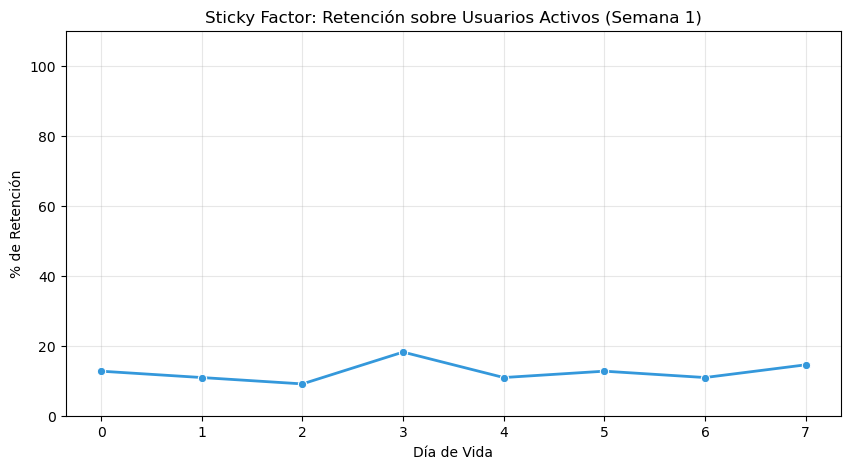

Usuarios únicos detectados con actividad en Semana 1: 55

Retención Normalizada por Día (%):
Dia_Vida
0    12.727273
1    10.909091
2     9.090909
3    18.181818
4    10.909091
5    12.727273
6    10.909091
7    14.545455
Name: ID_Usuario, dtype: float64


In [2]:
# 1. Universo de "Usuarios Activados": los que tuvieron actividad real en la semana 1
usuarios_activados = df_onboarding['ID_Usuario'].nunique()

# 2. Usuarios únicos por cada día (0 al 7)
usuarios_por_dia = df_onboarding.groupby('Dia_Vida')['ID_Usuario'].nunique()

# 3. Sticky Factor: Retención relativa a los que entraron en la semana
retencion_normalizada = (usuarios_por_dia / usuarios_activados) * 100

# 4. Gráfico de Calidad para el Informe
plt.figure(figsize=(10, 5))
sns.lineplot(x=retencion_normalizada.index, y=retencion_normalizada.values, marker='o', color='#3498db', linewidth=2)
plt.title('Sticky Factor: Retención sobre Usuarios Activos (Semana 1)', fontsize=12)
plt.ylabel('% de Retención')
plt.xlabel('Día de Vida')
plt.ylim(0, 110)
plt.grid(True, alpha=0.3)

# Exportación de la métrica clave de Onboarding
plt.savefig('figures/fig_retencion_sticky_factor.png', dpi=300, bbox_inches='tight')

plt.show()

print(f"Usuarios únicos detectados con actividad en Semana 1: {usuarios_activados}")
print("\nRetención Normalizada por Día (%):")
print(retencion_normalizada)

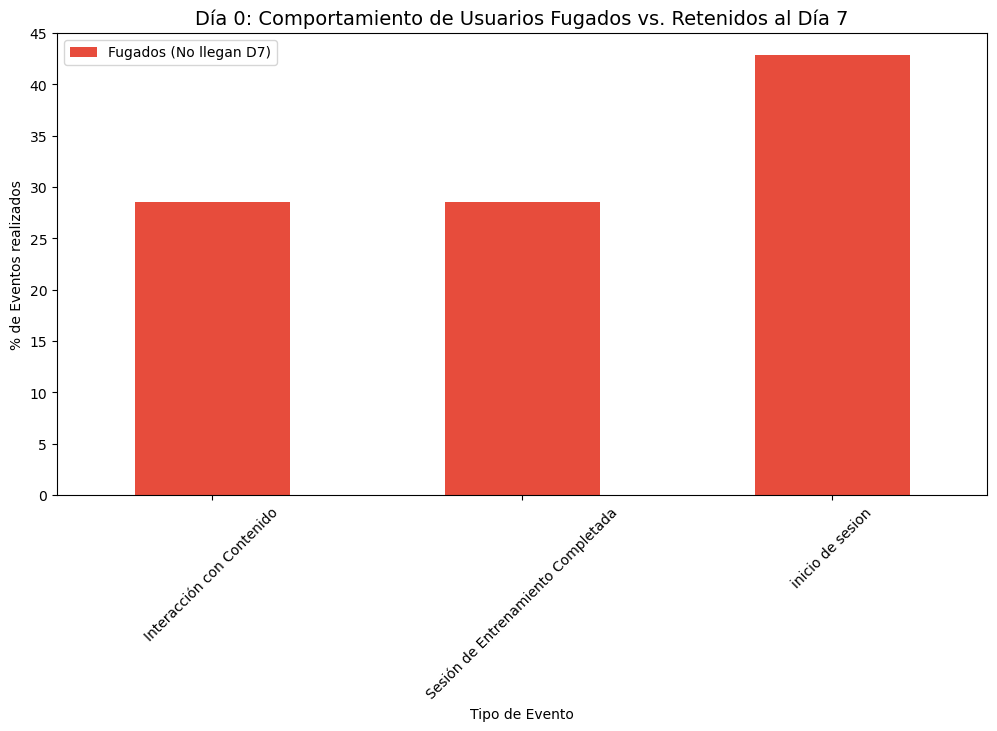

Diferencia en comportamiento inicial (%):


Tipo_Evento,Interacción con Contenido,Sesión de Entrenamiento Completada,inicio de sesion
Es_Retenido_D7,,,
False,28.571429,28.571429,42.857143


In [3]:
# 1. Identificamos a los usuarios que llegaron al Día 7 (Retenidos de Éxito)
usuarios_dia7 = df_onboarding[df_onboarding['Dia_Vida'] == 7]['ID_Usuario'].unique()

# 2. Creamos una etiqueta en el dataframe de onboarding
df_onboarding['Es_Retenido_D7'] = df_onboarding['ID_Usuario'].isin(usuarios_dia7)

# 3. Comparamos el mix de eventos del Día 0 entre ambos grupos
comportamiento_dia0 = df_onboarding[df_onboarding['Dia_Vida'] == 0].groupby(
    ['Es_Retenido_D7', 'Tipo_Evento']
).size().unstack(fill_value=0)

# Normalizamos para comparar porcentajes
comportamiento_dia0_pct = comportamiento_dia0.div(comportamiento_dia0.sum(axis=1), axis=0) * 100

# 4. Visualización de contraste
comportamiento_dia0_pct.T.plot(kind='bar', figsize=(12, 6), color=['#e74c3c', '#2ecc71'])
plt.title('Día 0: Comportamiento de Usuarios Fugados vs. Retenidos al Día 7', fontsize=14)
plt.ylabel('% de Eventos realizados')
plt.xlabel('Tipo de Evento')
plt.xticks(rotation=45)
plt.legend(['Fugados (No llegan D7)', 'Éxito (Llegan D7)'])
plt.show()

print("Diferencia en comportamiento inicial (%):")
display(comportamiento_dia0_pct)

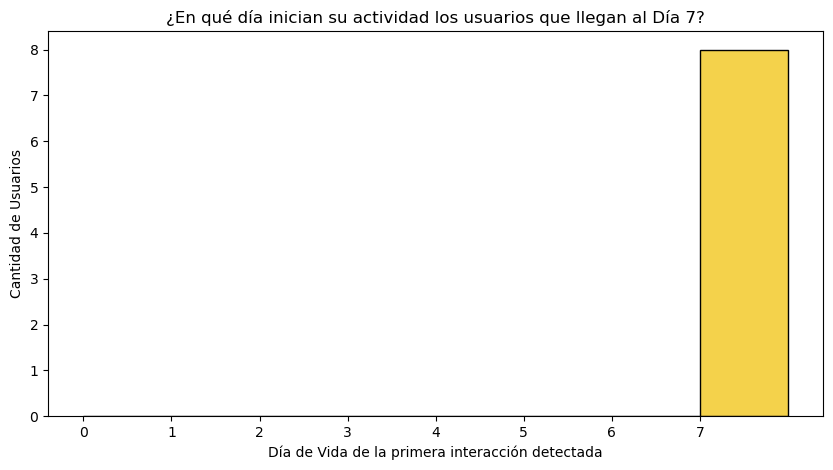

Distribución del primer día de actividad (Usuarios Exitosos):
Dia_Vida
7    8
Name: count, dtype: int64


In [4]:
# 1. Identificamos el primer día de actividad registrado para cada usuario de éxito
primer_dia_exito = df_onboarding[df_onboarding['Es_Retenido_D7'] == True].groupby('ID_Usuario')['Dia_Vida'].min()

# 2. Visualización del "Día de Despertar"
plt.figure(figsize=(10, 5))
if not primer_dia_exito.empty:
    sns.histplot(primer_dia_exito, bins=range(9), kde=False, color='#f1c40f')
    plt.title('¿En qué día inician su actividad los usuarios que llegan al Día 7?', fontsize=12)
    plt.xlabel('Día de Vida de la primera interacción detectada')
    plt.ylabel('Cantidad de Usuarios')
    plt.xticks(range(8))
    plt.show()
    
    print("Distribución del primer día de actividad (Usuarios Exitosos):")
    print(primer_dia_exito.value_counts().sort_index())
else:
    print("⚠️ Confirmado: Ningún usuario que llegó al Día 7 tuvo actividad registrada en su primera semana.")